In [1]:
import numpy as np
from scipy.optimize import linprog
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from sklearn import linear_model
from pmdarima import auto_arima
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose

## Закачка и отборы в/из ПХГ по странам EU

In [2]:
col_labels = {
    'status': 'status',
    'gasInStorage':'Остатки',
    'full':'%',
    'trend':'Изменение',
    'injection':'Закачка',
    'withdrawal':'Отбор',
    'workingGasVolume':'Рабочий объём',
    'injectionCapacity':'макс. закачка',
    'withdrawalCapacity':'макс. отбор',
    'info':'info'}

county_codes = {'eu':'Europe', 'AT':'Austria', 'BE': 'Belgium', 'BG':'Bulgaria',
                'HR':'Croatia', 'CZ':'Czech Republic', 'DK':'Denmark', 'FR':'France',
                'DE':'Germany', 'HU':'Hungary', 'IE':'Ireland', 'IT':'Italy', 'LV':'Latvia',
                'NL':'Netherlands', 'PL':'Poland', 'PT':'Portugal', 'RO':'Romania',
                'SK':'Slovakia', 'ES':'Spain', 'SE':'Sweden', 'GB':'United Kingdom',
                'RS':'Serbia', 'UA':'Ukraine'}

Исторические данные по заполнению ПХГ Европы берем из системы AGSI+ начиная с 7 апреля 2016 года в соответсвии с [рекомендацией](https://agsi.gie.eu/#/faq).

In [ ]:
# Загрузка данных
dfs ={}
for code in county_codes:
    df = pd.read_json(f'https://agsi.gie.eu/api/data/{code}?from=2016-04-07')
    df['gasDayStartedOn'] =pd.to_datetime(df['gasDayStartedOn'])
    df.set_index('gasDayStartedOn', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    dfs[code] = df


В виду свободной постановки задачи визуализации отборов в/из ПХГ (не указанно на какие вопросы должна отвечать визуализация), пострим диаграмму распределения сумарных, годовых отборов по странам. Такая диаграмма даст общее понимание о балансе ПХГ.

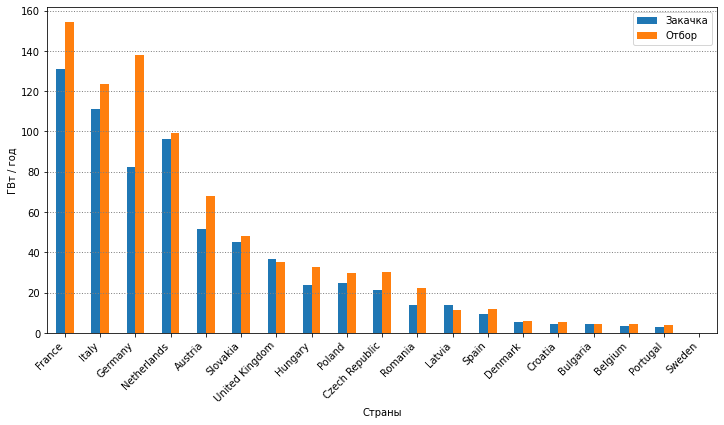

In [ ]:
mm = pd.DataFrame()
ll = []
for key, df in dfs.items():
    if key not in {'eu', 'UA', 'Serbia'}:
        try:
            df = df[('2020-01-01'<=df.index) & (df.index<='2020-12-31')]
            ddf=df
            ddf = df.resample('M').sum()
            ddf = (ddf[['injection', 'withdrawal']]/1000)
            ddf['s']= ddf['injection']+ddf['withdrawal']
            ddf['Страны']=county_codes[key]
            ll.append(ddf.copy())          
        except:
            continue

vv = pd.concat(ll)
fig, ax = plt.subplots(figsize=(12,6))
mm = vv.groupby(by='Страны').sum().sort_values(by=['s','injection', 'withdrawal'], ascending=False)
mm[['injection', 'withdrawal']].plot.bar(ax=ax)
ax.legend(['Закачка', 'Отбор'])

plt.grid(color='grey', axis='y', linestyle=':', linewidth=1)
ax.set_ylabel('ГВт / год')
ax.set_xticklabels(mm.index,rotation=45, ha='right')
fig.savefig('gas_by_country.svg', format='svg') 
plt.show()

Также построим профиль закачки газа в ПХГ по странам. Для уменьшения визуальной нагрузки, отбросим страны дающие наименьший вклад в баланс (сумарный вклад менее 5%).

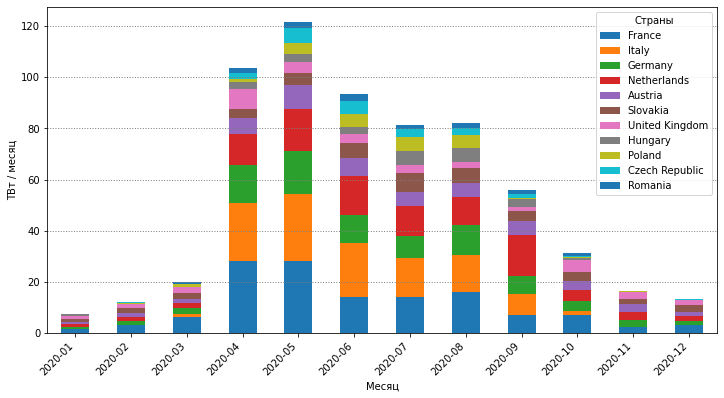

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ii = mm[(mm['s'].cumsum()/mm['s'].sum())<=0.95].index.values
aa = vv[vv['Страны'].isin(ii)]
cc = pd.pivot_table(aa, values='injection', index=aa.index, columns='Страны', aggfunc=np.sum)
cc = cc.reindex(ii, axis=1)

cc.plot.bar(stacked=True, ax=ax)
date_form = DateFormatter('%d')
ax.xaxis.set_major_formatter(date_form)

ax.set_xlabel('Месяц')
ax.set_ylabel('ТВт / месяц')
ax.set_xticklabels(cc.index.strftime('%Y-%m'),rotation=45, ha='right')
plt.grid(color='grey', axis='y', linestyle=':', linewidth=1)
fig.savefig('gas_by_m12.svg', format='svg') 
plt.show()

Стоит упомянуть, что диаграммы выше построены на данных ASGI+ и в них есть не до конца понятная неувязка в данных.
Балансовое значение разности колонок **injection**(закачка) и **withdrawal**(отбор), дают отличное значение от накопленного объёма газа в течении года **gasInStorage** (объём газа в ПХГ) по ряду стран. Эта разбежка представленная на рисунках ниже. Данный факт ставит под сомнение построенные выше диаграмы и требует более тщательного изучения.

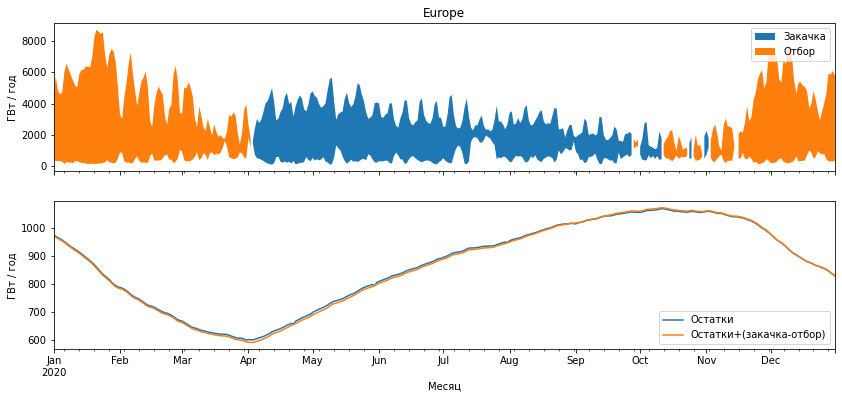

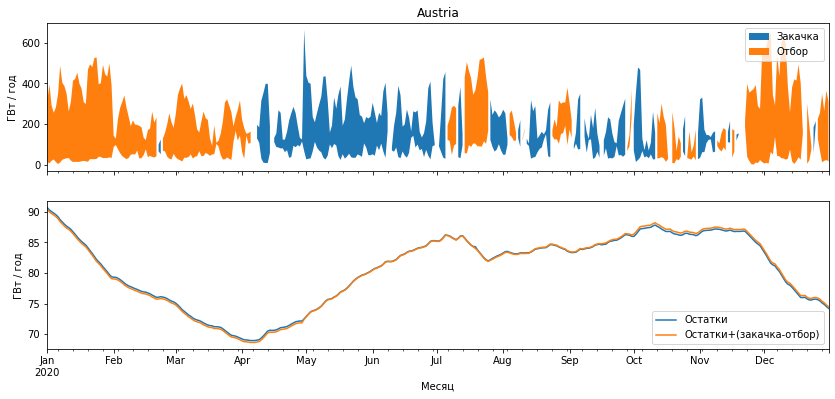

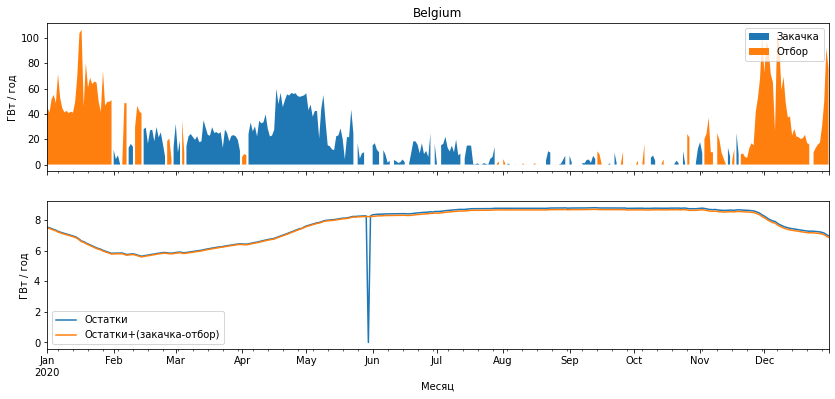

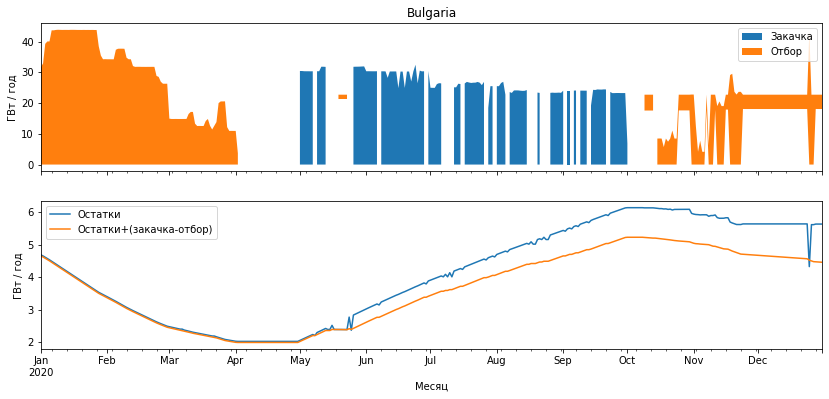

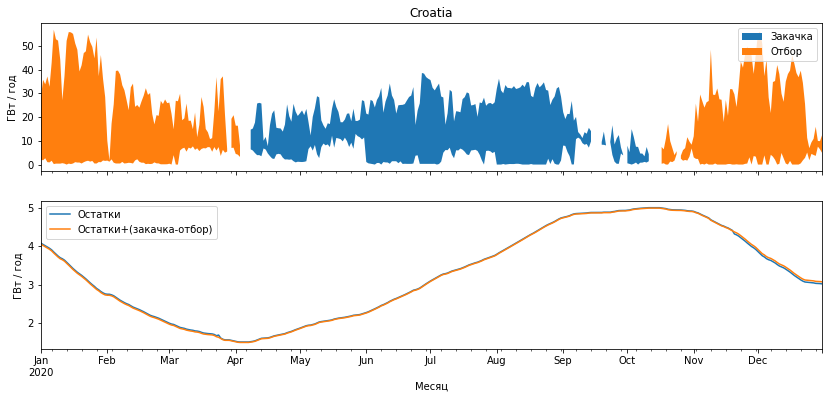

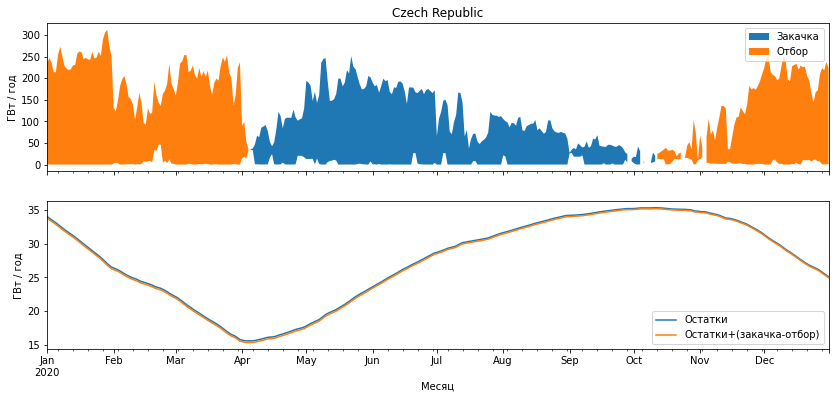

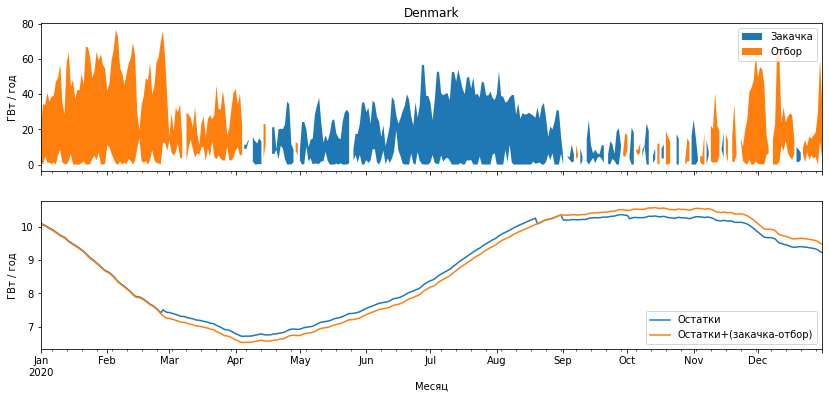

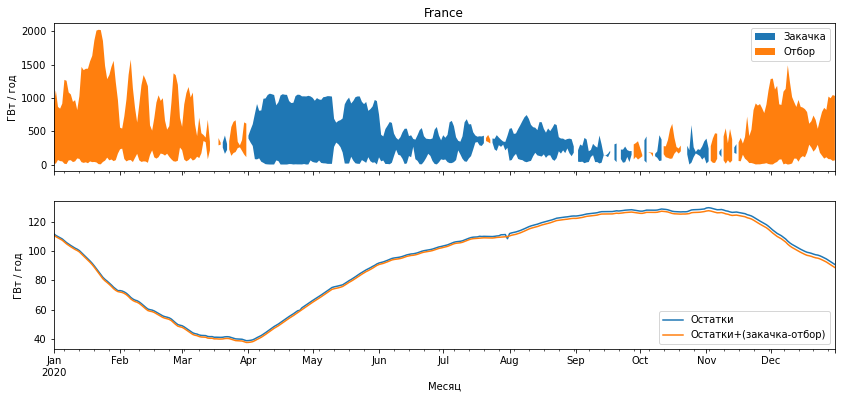

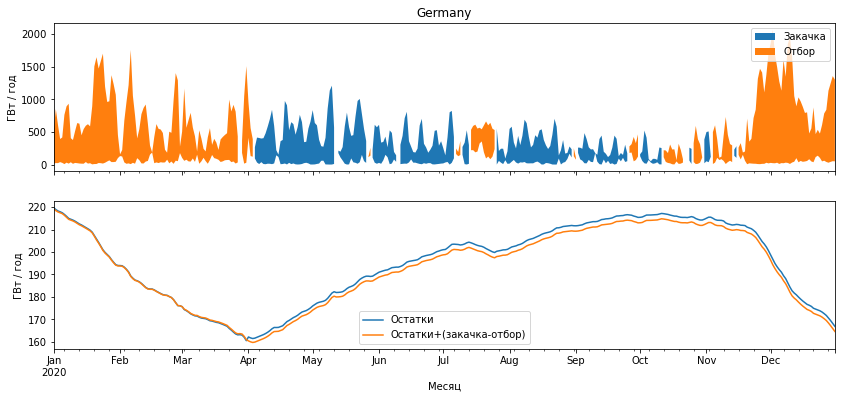

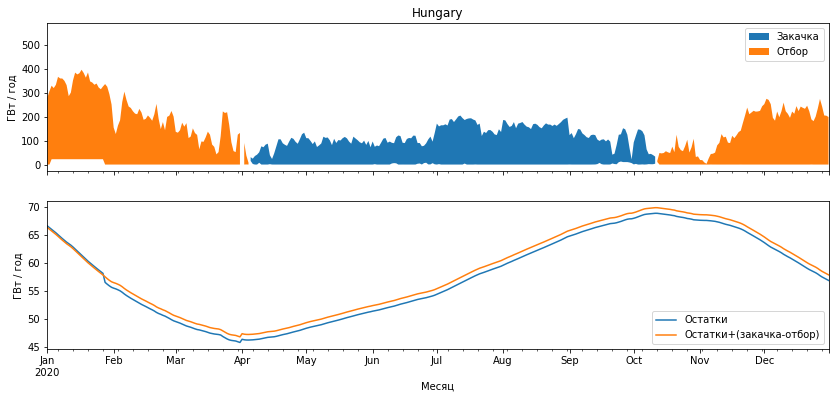

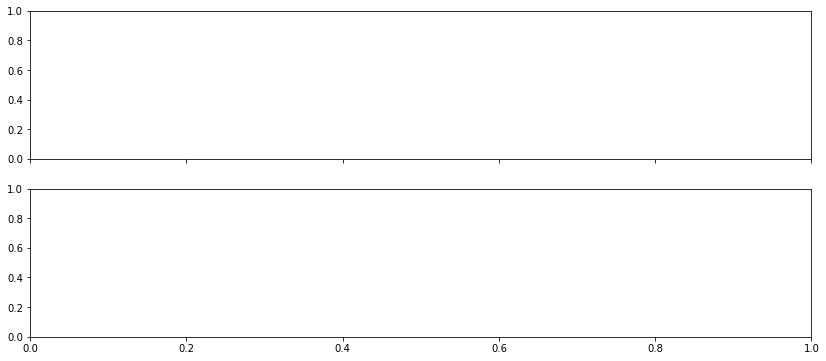

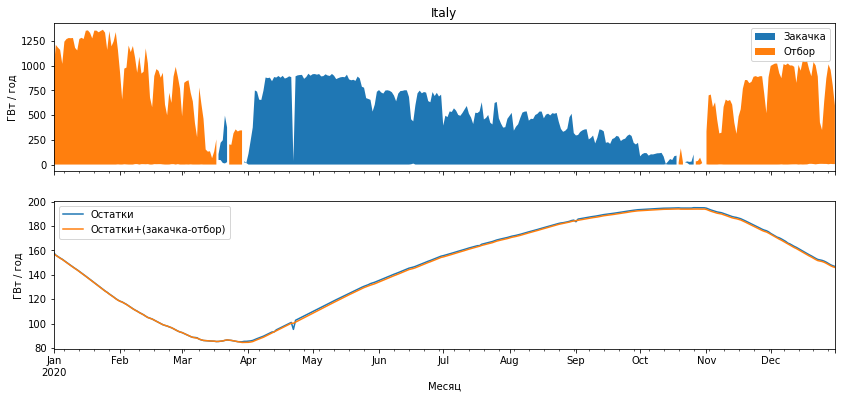

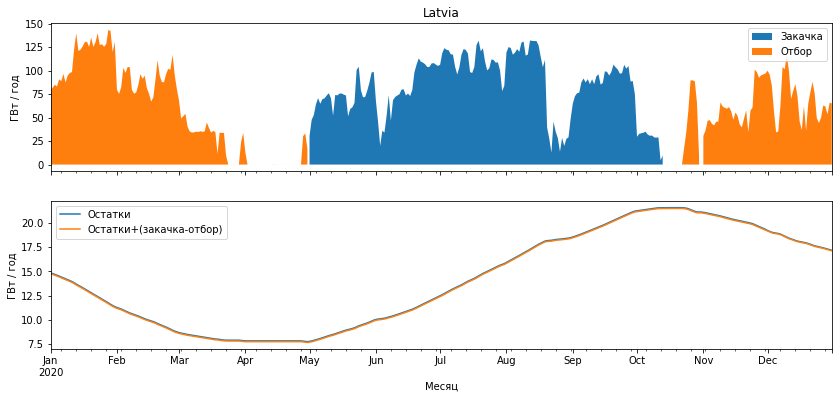

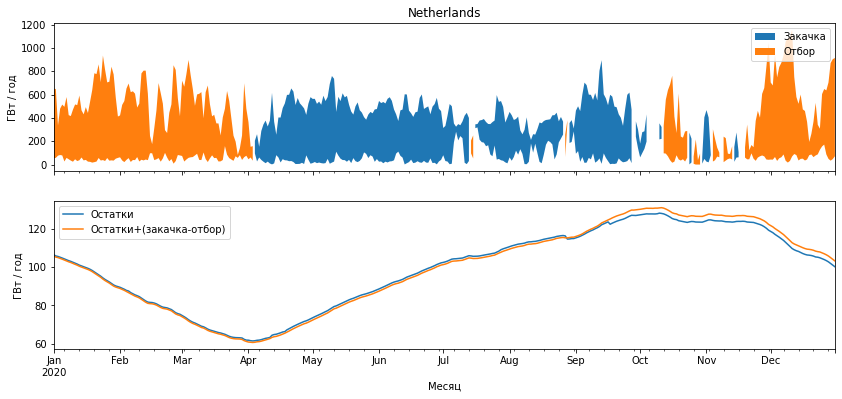

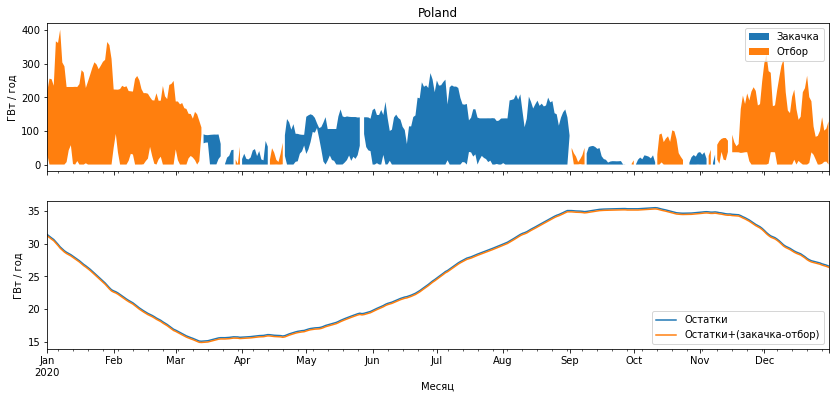

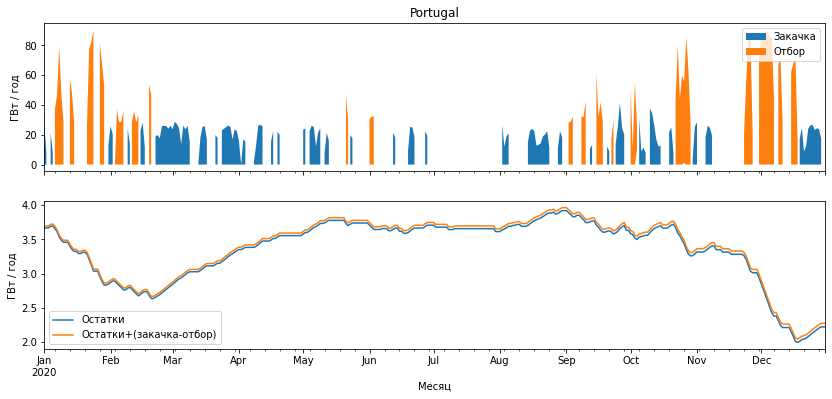

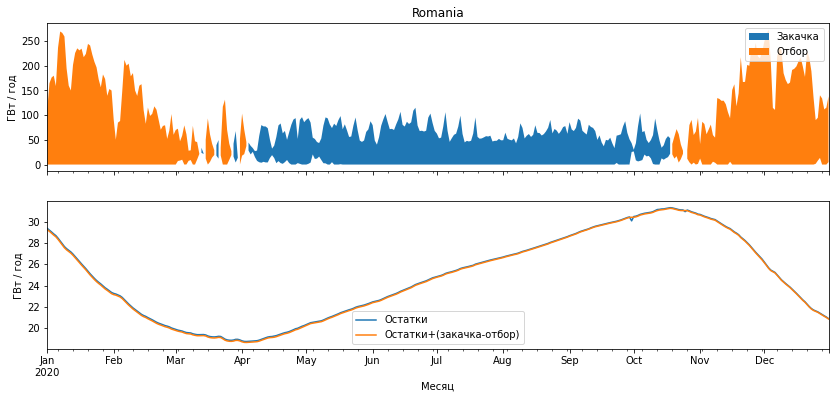

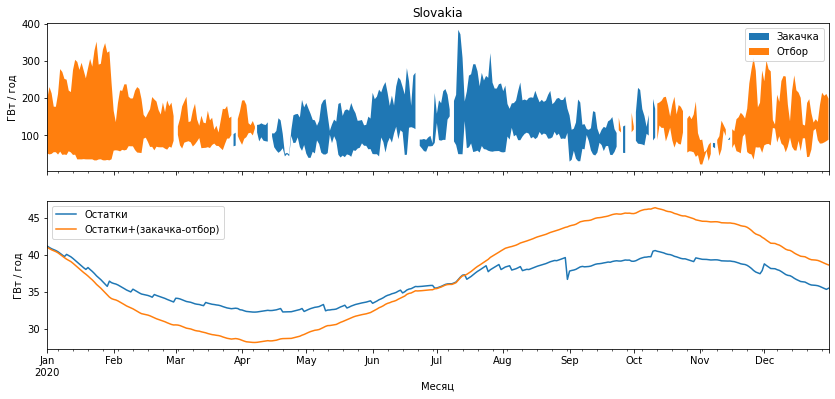

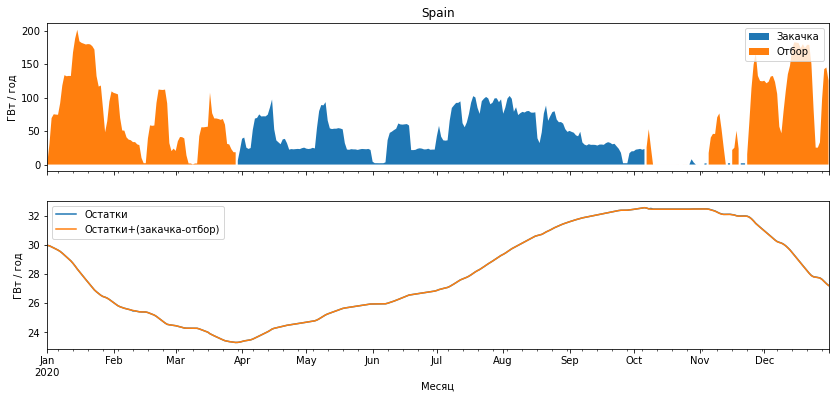

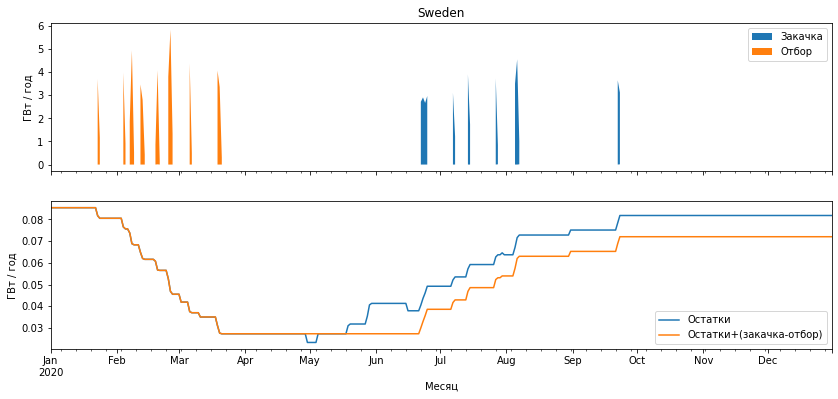

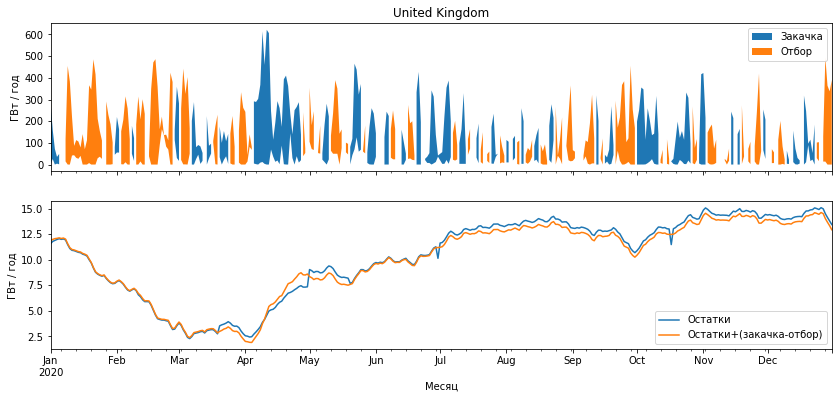

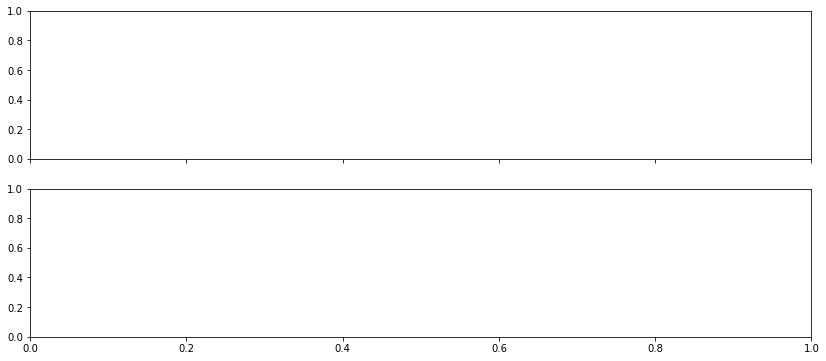

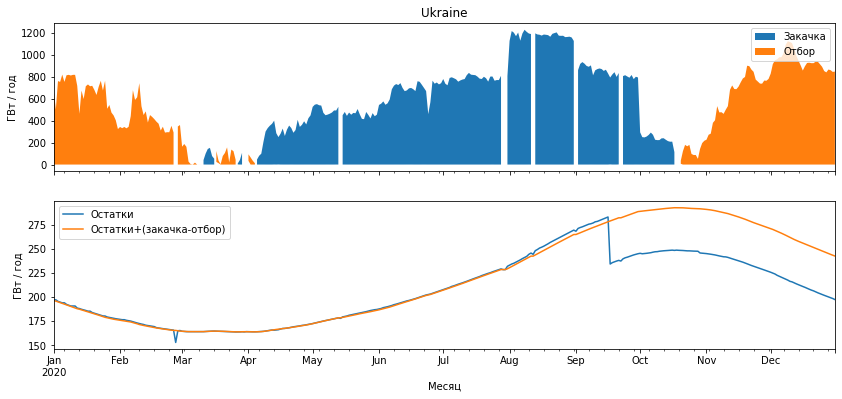

In [ ]:
for key, df in dfs.items():
    try:
        df1 = df[('2020-01-01'<=df.index) & (df.index<='2020-12-31')].copy()
        fig, ax = plt.subplots(2,1, figsize=(14,6), sharex=True)
        b = df1['injection']-df1['withdrawal']

        ax[0].fill_between(df1.index, df1['withdrawal'], df1['injection'], where=b>0)
        ax[0].fill_between(df1.index, df1['withdrawal'], df1['injection'], where=b<0)
        ax[0].legend(['Закачка', 'Отбор'])
        ax[0].set_title(county_codes[key])
        ax[0].set_ylabel('ГВт / год')
        df1 ['pp']= ((df1['injection']-df1['withdrawal'])/1000)
        df1.loc['2020-01-01', 'pp'] += df1.loc['2020-01-01','gasInStorage']
        df1['pp']=df1['pp'].cumsum()

        df1[['gasInStorage', 'pp']].plot(ax=ax[1])

        ax[1].set_ylabel('ГВт / год')
        ax[1].set_xlabel('Месяц')
        ax[1].legend(['Остатки', 'Остатки+(закачка-отбор)'])

        plt.show()
    except:
        continue

## Прогнозирвоание остатвок в ПХГ Европы

Построим график сезонности:

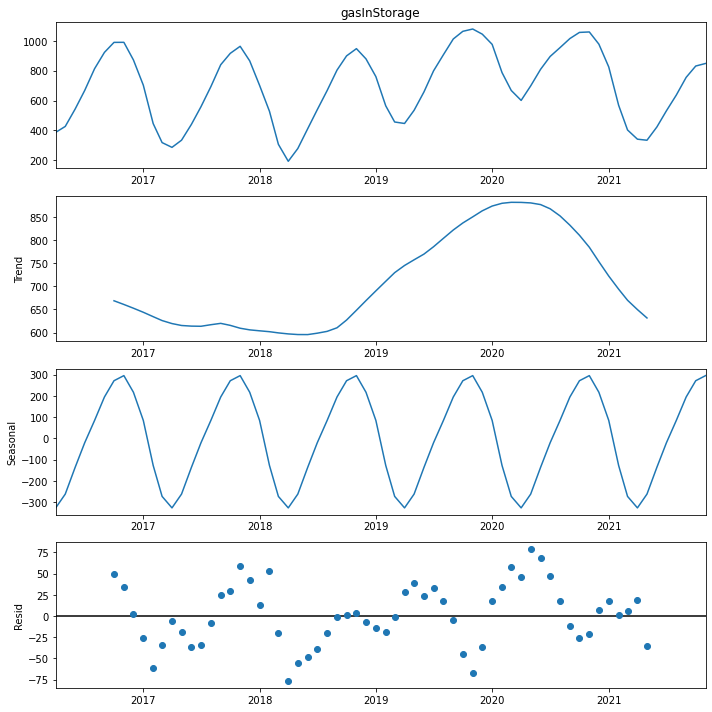

In [ ]:
df = dfs['eu']['gasInStorage']
#dfm = df
dfm = df.resample('MS').first()
#print(dfm.shape[0], dfm)
#dfm.plot(figsize=(18,8))
dec = seasonal_decompose(dfm, model='additive')

# Построение графика
plt.rcParams.update({'figure.figsize': (10,10)})
dec
dec.plot()
plt.show()

Из графика сезонности видно, что объём газа в ПХГ Европы имеет ярко выражженую сезонность. С учётом этого факта для прогнозирования воспользуеся авторегресионной моделью $SARIMA(p,d,q)(P,D,Q)_m$ где параметры $p,d,q,P,D,Q$ подбираются автоматически (подробнее об атоподборе параметров указано [здесь](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)). А параметр $m$ (периодичность сезона) устанавливается равным 12.

Для сокращения времени обучения, в качестве исходных данных для обучения будет использоватся не весь набор, а только первые дни каждого клендарного месяца.

In [ ]:
model = auto_arima(dfm, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore', stepwise=False)
sarimax_mod = SARIMAX(dfm, order=model.order, scoring_args=model.scoring_args, seasonal_order=model.seasonal_order, suppress_warnings=True)
sarimax_res = sarimax_mod.fit()
print(sarimax_res.summary())

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=943.533, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=898.669, Time=0.34 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=929.912, Time=2.12 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.55 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=869.896, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=820.825, Time=0.24 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=861.413

/usr/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   30    f=  5.11909D+00    |proj g|=  7.44772D-03

At iterate   35    f=  5.11755D+00    |proj g|=  1.02343D-02
  ys=-6.622E-03  -gs= 1.936E-03 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     61      1     1     0   1.024D-02   5.118D+00
  F =   5.1175515442684603     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                       gasInStorage   No. Observations:                   68
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihoo


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Оценка: 649.5 ТВт
95% доверительный интервал: [569.7 729.2] ТВт


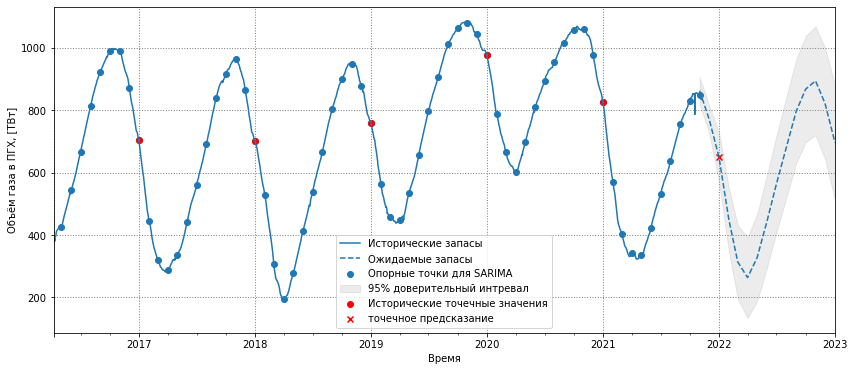

In [ ]:
sarima_pred = sarimax_res.get_prediction("11-2021", "01-2023")
fig, ax = plt.subplots(figsize=(14,6))
a = dfm.loc[[ f'20{yy}-01-01' for yy in range(17,22)]]
df.plot(ax=ax, color='tab:blue')
plt.scatter(dfm.index.values, dfm.values, color='tab:blue')
pred = sarima_pred.predicted_mean
pred.plot(ax=ax, style='--', color='tab:blue')
ci = sarima_pred.conf_int(alpha=0.15)
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='grey', alpha=0.15)
plt.scatter(a.index.values, a.values, color='r')
plt.scatter('2022-01-01', pred.loc['2022-01-01'], color='r', marker='x')
ax.legend(['Исторические запасы','Ожидаемые запасы', 'Опорные точки для SARIMA', '95% доверительный интревал','Исторические точечные значения', 'точечное предсказание'])
ax.set_xlabel('Время')
ax.set_ylabel('Объём газа в ПГХ, [ТВт]')
plt.grid(color='grey', linestyle=':', linewidth=1)
print(
    f'Оценка: {pred.loc["2022-01-01"].round(1)} ТВт\n'
    f'95% доверительный интервал: {ci.loc["2022-01-01"].values.round(1)} ТВт')
fig.savefig('opt.svg', format='svg')

Построим диагностические графики для полученной модели.

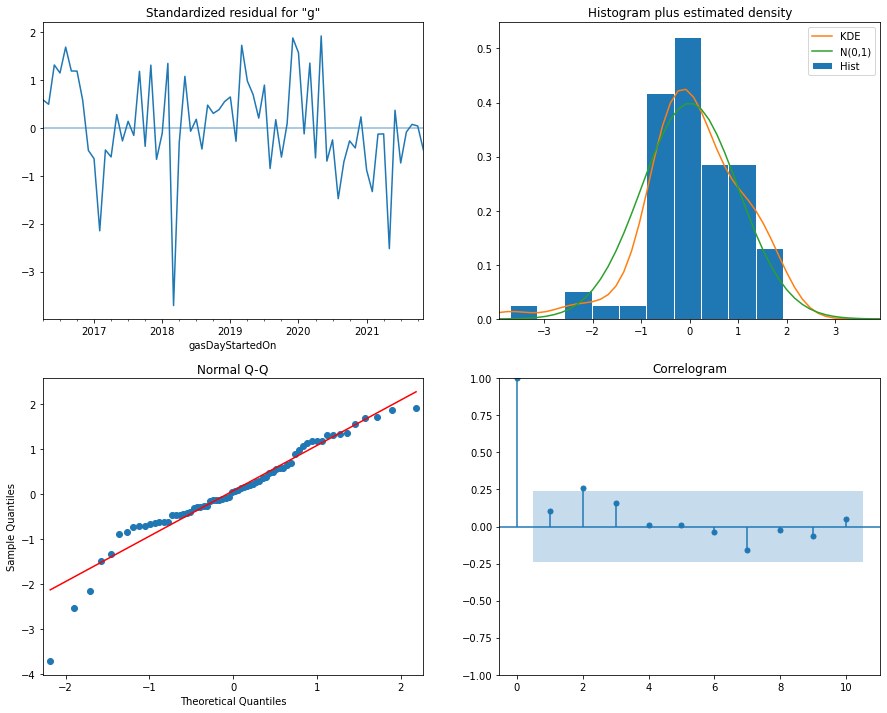

In [ ]:
sarimax_res.plot_diagnostics(figsize=(15, 12))
plt.show()